# Hand-calculated derivative rules: Error prone

Hand-computation of derivatives of complicated functions involving vectors and matrices is **error-prone**, and is a common source of bugs when performing numerical optimization, root-finding, sensitivity-analysis, etcetera.

The ideal alternative is to use **automatic differentiation (AD)**:
* AD lets software/compilers perform the derivatives for you.  This is extremely reliable and, with modern AD software, can be very efficient.
* Unfortunately, there is still lots of code, e.g. code calling external libraries in other languages, that AD tools can't comprehend.
* And there are other cases where AD "needs help" — for example, if you are computing an answer *approximately* (e.g. solving a nonlinear equation by Newton's method), AD can waste a lot of effort trying to *exactly differentiate the error* in your approximation.   Often, you can compute the approximate answer (to the same accuracy) much more efficiently.
* Even in cases where AD falls down, often you only need to give it a **little help**: define a differentiation rule for a *small piece* of your program and let AD handle the rest.  In Julia, this is done with by defining a ["ChainRule"](https://github.com/JuliaDiff/ChainRulesCore.jl), and in Python autograd/JAX it is done by defining a custom "vJp" (row-vector—Jacobian product) and/or "Jvp" (Jacobian–vector product).

If you do have to work out your own derivative rule, you *really* need to **check** it against something "brute force" and hard to get wrong.  The usual candidate is…

# Finite-difference approximations: Easy version

The simplest way to check a derivative is to recall that the definition of a differential:
$$
df = f(x+dx) - f(x) = f'(x) dx
$$
came from dropping higher-order terms from a small but finite difference:
$$
\delta f = f(x+\delta x) - f(x) = f'(x) \delta x + o(\Vert \delta x \Vert)
$$
So, we can just compare the **finite difference** $\boxed{f(x+\delta x) - f(x)}$ to our **(directional) derivative operator** $f'(x) \delta x$ (i.e. the derivative in the direction $\delta x$).

$f(x+\delta x) - f(x)$ is also called a **forward difference** approximation.  We'll look at other possibilities below.

* The antonym of a forward diffence is a **backward difference** approximation $f(x) - f(x - \delta x) \approx f'(x) \delta x$ … if you just want to compute a derivative, there is not much practical distinction between forward and backward differences.  The distinction becomes more important when discretizing (approximating) differential equations.

* Finite-difference approximations come in many forms, but they are generally a **last resort** in cases where it's too much effort to work out an analytical derivative and AD fails.  But they are also useful to **check** your analytical derivatives and to quickly **explore**.

## example: f(A)=A²

Let's try it for $f(A) = A^2$ (a matrix-valued function of a square matrix $A \in \mathbb{R}^{m\times m}$).

First, we'll do it by hand via the product rule:

$$
df = A dA + dA A
$$
i.e. $f'(A)$ is the **linear operator** $\boxed{f'(A)[\delta A] = A \delta A + \delta A A}$.  This is **≠ 2AδA** because because **A and δA do not commute** in general.

Let's check it against a finite difference.   We'll try it for a *random* input A and a *random small* perturbation $\delta A$:

In [1]:
f(A) = A^2

A = randn(4,4) # 4×4 matrix with Gaussian random (bell curve) entries of magnitude ~ 1 (std. dev = 1)

4×4 Matrix{Float64}:
 -2.1088     0.734105   0.239804     0.769526
 -0.50642    1.3228     0.820155    -0.155089
 -0.57114   -0.600107  -0.00180516  -1.41079
  0.160461   0.874805  -0.642604    -0.5685

In [2]:
dA = randn(4,4) * 1e-8 # a small random perturbation ~ 10⁻⁸

4×4 Matrix{Float64}:
 1.07507e-8   7.14782e-9  -1.93596e-9   1.54683e-9
 1.38533e-8   1.54251e-8   1.97596e-8  -1.5794e-8
 9.02758e-9  -2.33086e-8   1.87726e-9   2.47228e-9
 2.16736e-9   7.34033e-9   6.54572e-9   8.20985e-9

In [3]:
approx = f(A + dA) - f(A) # finite difference

4×4 Matrix{Float64}:
 -3.36055e-8   1.61716e-8   3.15253e-8   1.07036e-9
 -3.08965e-8   1.42894e-9   5.37296e-8  -3.15509e-8
 -2.54365e-8  -4.68219e-8  -3.85341e-8   3.51576e-9
 -3.89827e-9   4.00008e-8   1.33e-8     -3.3197e-8

In [4]:
exact = A*dA + dA*A # exact directional derivative (linearization)

4×4 Matrix{Float64}:
 -3.36055e-8   1.61716e-8   3.15253e-8   1.07036e-9
 -3.08965e-8   1.42894e-9   5.37296e-8  -3.15509e-8
 -2.54365e-8  -4.68219e-8  -3.85341e-8   3.51576e-9
 -3.89827e-9   4.00008e-8   1.33e-8     -3.3197e-8

In [5]:
2A*dA # wrong! matrices don't commute

4×4 Matrix{Float64}:
 -1.73372e-8  -7.38125e-9   4.81509e-8  -1.58918e-8
  3.98974e-8  -6.9411e-9    5.52859e-8  -4.18427e-8
 -3.50552e-8  -4.73053e-8  -3.99804e-8  -5.98437e-9
  1.36214e-8   5.08921e-8   2.40952e-8  -3.9649e-8

In [6]:
2A*dA - approx

4×4 Matrix{Float64}:
  1.62684e-8  -2.35529e-8    1.66256e-8  -1.69621e-8
  7.07939e-8  -8.37003e-9    1.5563e-9   -1.02918e-8
 -9.61869e-9  -4.83447e-10  -1.44632e-9  -9.50013e-9
  1.75197e-8   1.08913e-8    1.07951e-8  -6.452e-9

To be more quantitative, we might compute the "norm" $\Vert \text{approx} - \text{exact} \Vert$, which we want to be small.   But small **compared to what?**   The natural answer is **small compared to the correct answer**.  This is called the [relative error](https://en.wikipedia.org/wiki/Approximation_error) (or "fractional" error):
$$
\text{relative error} = \frac{\Vert \text{approx} - \text{exact} \Vert}{\Vert \text{exact}\Vert}
$$
Here, $\Vert \cdot \Vert$ is a [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)), like the length of a vector. In Julia, the `LinearAlgebra` package provides a `norm` function, and we can use that to define a relative error:

In [7]:
using LinearAlgebra

relative_error(approx, exact) = norm(approx - exact) / norm(exact)

relative_error (generic function with 1 method)

Let's try it on our case above:

In [8]:
relative_error(approx, exact)

1.201810486737118e-8

Pretty good — we are matching to **about eight significant digits**!

Getting a good match for a random input and a random small displacement isn't a proof of correctness, but it is always a good thing to check.   This kind of randomized comparison will almost always **catch major bugs** where you have calculated the symbolic derivative incorrectly, like our $2AdA$ example:

In [9]:
relative_error(2A*dA, exact)

0.7126976615760792

Here, for our buggy derivative, the relative error was **close to 50%**.

### aside: norm of a matrix?

Wait, what do we mean by the norm $\Vert A \Vert$ of a matrix $A$?

The ordinary Euclidean ("L2") norm of a column-vector $x \in \mathbb{R}^n$ is $\Vert x \Vert = \sqrt{x^T x} = \sqrt{\sum_i x_i^2}$.

For a matrix, the natural analogue is the **sqrt of the sum of the squares of the entries**.  This is called the [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html), and is what `norm(A)` does in Julia by default.

In [10]:
using Symbolics

@variables m11 m12 m13 m21 m22 m23
M = [m11 m12 m13
     m21 m22 m23]

2×3 Matrix{Num}:
 m11  m12  m13
 m21  m22  m23

In [11]:
norm(M)

sqrt(abs2(m11) + abs2(m12) + abs2(m13) + abs2(m21) + abs2(m22) + abs2(m23))

(`abs2(x)` in Julia is the squared absolute value $|x|^2$.)

But we can write this in linear algebra notation!

Recall that the (Euclidean) "inner product" of two matrices is $\text{tr}(B^T A)$.   Then we can define the Frobenius norm of a matrix as the sqrt of the dot product with itself!

$$
\Vert A \Vert_F = \sqrt{\text{trace}(A^T A)}
$$

In [12]:
norm(A)

3.541526593233751

In [13]:
sqrt(tr(A'A))

3.5415265932337516

In [14]:
sqrt(sum(abs2, A))

3.541526593233751

In [15]:
sqrt(sum(A[i,j]^2 for i = 1:4, j = 1:4))

3.541526593233751

(There are also other ways to define a norm of matrix, most famously by "induced norms", but we will stick with the Frobenius norm here.)

# Accuracy of finite differences

How accurate is our finite-difference approximation above?  How should we choose the size of δx?

Let's try our example $f(A) = A^2$ above, and plot the relative error as a function of $\Vert \delta A \Vert$ as we scale $\delta A$ by a factor $s$, making it larger or smaller.

In [16]:
using Plots # load a plotting package; there are several to choose from in Julia; this is a popular one
using LaTeXStrings # makes it easy to put LaTeX equations in L"..." strings

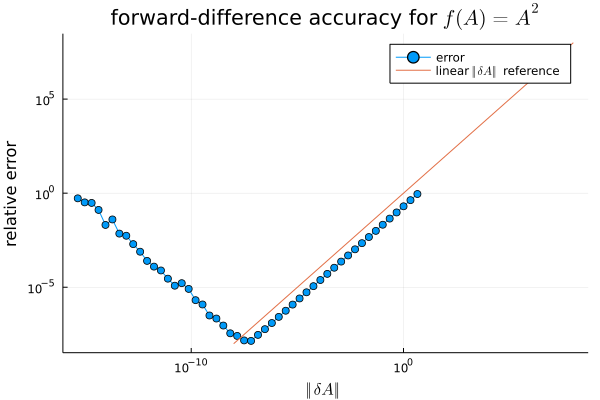

In [17]:
s = 10 .^ range(-8,8,50)
errors = [relative_error(f(A+s*dA)-f(A), exact*s) for s in s]
plot(s * norm(dA), errors, xaxis=:log, yaxis=:log, markershape=:circle,
     title = L"forward-difference accuracy for $f(A)=A^2$", xlabel=L"\Vert \delta A\Vert", ylabel="relative error",
     label = "error")
plot!(s, s, label=L"linear $\Vert \delta A\Vert$ reference")

We observe two main features:

* The relative error decreases *linearly* with $\Vert \delta A \Vert$.  This is called **first-order accuracy**.  Why?
* When δA gets too small, the error *increases*.  Why?

## Order of accuracy

If the relative error scales with $\Vert \delta A \Vert^n$, we call the approximation **n-th order accurate**.  For forward differences, here, the order is **n=1**.  Why?

For any $f(x)$ with a nonzero second derivative (think of the Taylor series), we have
$$
    f(x + \delta x) = f(x) + f'(x) \delta x + (\text{terms proportional to }\Vert \delta x \Vert^2) + \underbrace{o(\Vert \delta x \Vert^2)}_\text{i.e. higher-order terms}
$$

That is, the terms we *dropped* in our forward-difference approximations are proportional to $\Vert \delta x\Vert^2$.  But that means that the **relative error is linear**:
$$
\begin{align}
  \text{relative error} &= \frac{\Vert f(x+\delta x) - f(x) - f'(x) \delta x \Vert}{\Vert f'(x) \delta x \Vert} \\
   &= \frac{(\text{terms proportional to }\Vert \delta x \Vert^2) + o(\Vert \delta x \Vert^2)}{\text{proportional to }\Vert \delta x \Vert} = (\text{terms proportional to }\Vert \delta x \Vert) + o(\Vert \delta x \Vert)
\end{align}
$$

## Roundoff error

The reason why the error *increased* for very small $\delta A$ was due to **roundoff errors**.  The computer only stores a **finite number of significant digits** (about 15 decimal digits) for each real number and rounds off the rest on each operation — this is called [floating-point arithmetic](https://en.wikipedia.org/wiki/Floating-point_arithmetic).

If δx is too small, then the difference $f(x+\delta x) - f(x)$ gets rounded off to zero (some or all of the *significant digits cancel*).  This is called [catastrophic cancellation](https://en.wikipedia.org/wiki/Catastrophic_cancellation).

Let's compute the derivative of $\sin(x)$ at $x=1$ with finite differences.   For a scalar $f(x)$, we have $f(x+\delta x) - f(x) \approx f'(x) \delta x$, or equivalently:

$$
f'(x) = \frac{f(x+\delta x) - f(x)}{\delta x} + \underbrace{O(\delta x)}_{\text{terms proportional to }|\delta x|\text{ or smaller}}
$$

(This is the usual way you see a forward difference approximation written, but it only works when $\delta x$ is a scalar.)

In [18]:
dx = 1e-5
(sin(1 + dx) - sin(1))/dx

0.5402980985058647

In [19]:
cos(1) # correct answer

0.5403023058681398

In [20]:
relative_error((sin(1 + dx) - sin(1))/dx, cos(1))

7.787052228587771e-6

So far, so good.  For $\delta x = 10^{-5}$, we got about 5–6 significant digits correct.  Now let's make $\delta x$ much smaller, $\delta x = 10^{-100}$:

In [21]:
dx = 1e-100
(sin(1 + dx) - sin(1))/dx

0.0

What happened?   The computer can represent small numbers just fine, because floating-point corresponds to "scientific notation":

In [22]:
1e-100

1.0e-100

But look at this:

In [23]:
1 + 1e-100

1.0

The correct answer would be
$$
1 + 10^{-100} = 1.\underbrace{000000\cdots000000}_{\text{99 zeros}}1
$$
but the computer only stores about 15 decimal digits (by default … you can ask for more, at the expense of speed), so it rounds this to $1.0$.

Hence, our finite difference gave zero.

Even if we do something less extreme, we have problems.   This looks okay:

In [24]:
dx = 1e-13
1 + dx

1.0000000000001

because the computer has enough digits, right?  But compare:

In [25]:
sin(1 + dx)

0.8414709848079505

In [26]:
sin(1)

0.8414709848078965

They only differ in the **last 4 significant digits stored**.  So when you subtract them, you only have **4 digits** left:

In [27]:
relative_error((sin(1 + dx) - sin(1))/dx, cos(1))

0.001358343083756518

and the error for $\delta x = 10^{-13}$ is now $10^{-3}$!!